In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sns
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
rc('text', usetex=True)
rc('font', family='serif')

In [2]:
def readh5files(file): 
    
    print('DATA FROM FILE:      ',file)
    hf = h5py.File(file, 'r')
  
    r = np.array(hf.get('radius'))
    phi = np.array(hf.get('phi'))
    z = np.array(hf.get('z'))
    rho = np.array(hf.get('rho'))
    vr = np.array(hf.get('vr'))
    vphi = np.array(hf.get('vphi'))
    vz = np.array(hf.get('vz'))
    Br = np.array(hf.get('br'))
    Bphi = np.array(hf.get('bphi'))
    Bz = np.array(hf.get('bz'))
      
    return [r,phi,z,Br.T, Bphi.T, Bz.T, vr.T, vphi.T, vz.T,rho.T]

def readstresses(arx):

    print('DATA FROM FILE:      ',arx)

    with h5py.File(arx, "r") as f:
    # List all groups
        print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())
        for i in a_group_key:
            print(i)

        Fmean = np.array(f.get('Fmean'))
        Rmean = np.array(f.get('Rmean'))
        Mmean = np.array(f.get('Mmean'))
        time = np.array(f.get('time'))
        rho = np.array(f.get('rhomean'))
        
        M = np.array([Mmean[0,0],Mmean[0,1],Mmean[0,2], Mmean[1,1], Mmean[1,2], Mmean[2,2]])
        R = np.array([Rmean[0,0],Rmean[0,1],Rmean[0,2], Rmean[1,1], Rmean[1,2], Rmean[2,2]])
        F = np.array([Fmean[0,1], Fmean[0,2], Fmean[1,2]])
        
        eT = 0.5*rho*(R[0]+R[3]+R[5])
        f.close()

        print('Time           :',time,' ms')

    return [M, R, F, eT, rho]

def readspectra(arx):
    
    print('DATA FROM FILE:      ',arx)
    hf = h5py.File(arx, 'r')
    
    t = np.array(hf.get('time'))
    ekin = np.array(hf.get('ekin'))
    emag = np.array(hf.get('emag'))
    k = np.array(hf.get('k'))
    
    print('Time = ', t)
    
    return [t, k, ekin, emag]

def energies(r,phi,z,B,v,rho):
    
    indr =  int(len(r)/2)
    r0 = r[indr]
    
    dphi = phi[1]-phi[0]
    dz = z[1]-z[0]
    dS = r0*dphi*dz
    dSmatrix = dS*np.ones((len(phi),len(z)))
    S = np.sum(dSmatrix)
    
    Bmodulus = np.sqrt(B[0]**2+B[1]**2+B[2]**2)
    Bener = 0.5*Bmodulus**2
    Benerx = 0.5*B[0]**2
    Benery = 0.5*B[1]**2
    Benerz = 0.5*B[2]**2
    
    vmodulus = np.sqrt(v[0]**2+v[1]**2+v[2]**2)
    vener = 0.5*rho*vmodulus**2
    venerx = 0.5*rho*v[0]**2
    venery = 0.5*rho*v[1]**2
    venerz = 0.5*rho*v[2]**2
    
    var_dec = [Bener[indr],Benerx[indr],Benery[indr],Benerz[indr],vener[indr],venerx[indr],venery[indr],venerz[indr]]
    meanvar=np.zeros(8)
  
    for i in range(0,8):
        integrand = dS*var_dec[i]
        meanvar[i] = np.sum(integrand)/S
    
    return meanvar

def energies_vol(r,phi,z,B,v,rho):
    
    rhalf = (r[1]-r[0])/2
 
    r_front = np.zeros(len(r)+1)
 
    r_front[0] = r[0]-rhalf
    r_front[-1] = r[-1]+rhalf
 
    for i in range(1,len(r)):
        r_front[i] = (r[i]+r[i-1])/2
 
    difr = np.zeros(len(r))
    for j in range(0,len(r)):
        difr[j] = r_front[j+1]**2-r_front[j]**2
        
    dphi = phi[1]-phi[0]
    dz = z[1]-z[0]
    dV = 0.5*difr*dphi*dz
    
    dVmatrix = dV*np.ones((len(r),len(phi),len(z)))
    V = np.sum(dVmatrix)
    
    Bmodulus = np.sqrt(B[0]**2+B[1]**2+B[2]**2)
    Bener = 0.5*Bmodulus**2
    Benerx = 0.5*B[0]**2
    Benery = 0.5*B[1]**2
    Benerz = 0.5*B[2]**2
    
    vmodulus = np.sqrt(v[0]**2+v[1]**2+v[2]**2)
    vener = 0.5*rho*vmodulus**2
    venerx = 0.5*rho*v[0]**2
    venery = 0.5*rho*v[1]**2
    venerz = 0.5*rho*v[2]**2
    
    var_dec = [Bener,Benerx,Benery,Benerz,vener,venerx,venery,venerz]
    meanvar=np.zeros(len(var_dec))
  
    for i in range(0,len(var_dec)):
        integrand = dV*var_dec[i]
        meanvar[i] = np.sum(integrand)/V
    
    return meanvar

def cuts_rphi_plane(r,phi,z,Bz):
    dphi = phi[1]-phi[0]
    dl = dphi*np.ones(len(phi))
    meanbz = np.zeros((len(r),len(z)))
    for i in range(0,len(r)):
        for j in range(0,len(z)):
            meanbz[i,j] = np.sum(Bz[i,:,j]*r[i]*dphi)/np.sum(r[i]*dphi)
    
    return meanbz

In [3]:
path_mri = '/media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil/'
t = np.linspace(0,30,61)
brt = np.zeros((len(t),100,400,100))
for i in range(0,len(t)):
    arx = format(25*i, "04")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_mri+'/mri-'+str(arx)+'.h5')  
    brt[i] = Br
    print('Time           : ',t[i])

DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0000.h5
Time           :  0.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0025.h5
Time           :  0.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0050.h5
Time           :  1.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0075.h5
Time           :  1.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0100.h5
Time           :  2.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0125.h5
Time           :  2.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8

Time           :  27.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-1375.h5
Time           :  27.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-1400.h5
Time           :  28.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-1425.h5
Time           :  28.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-1450.h5
Time           :  29.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-1475.h5
Time           :  29.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-1500.h5
Time           :  30.0


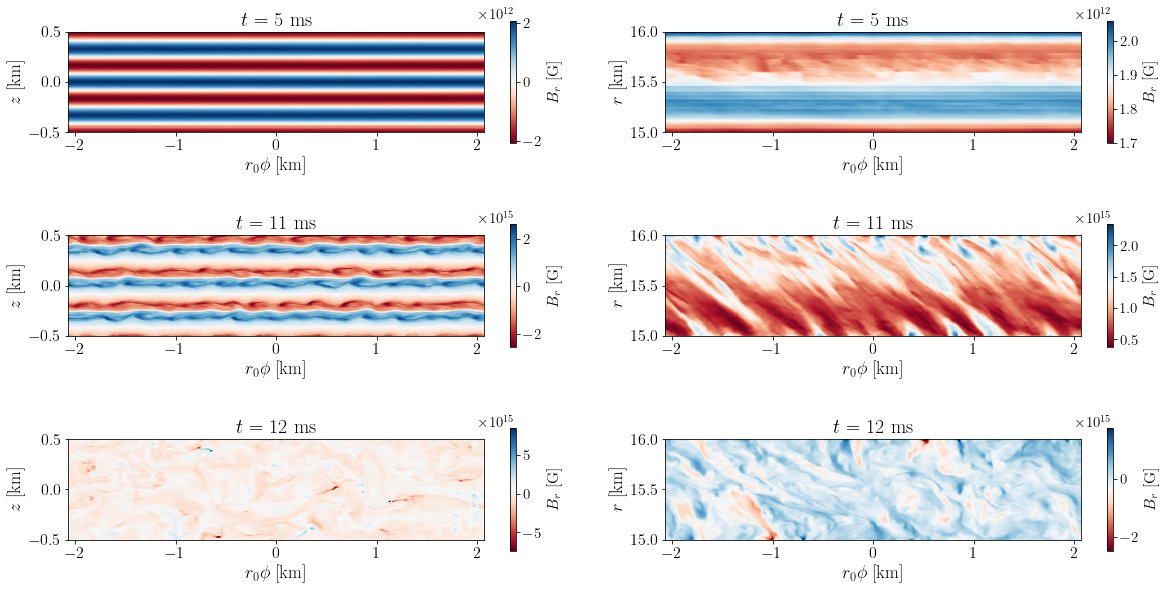

In [4]:
fig, ax = plt.subplots(3,2,figsize = (20,10))
plt.subplots_adjust(hspace = 0.5) 
plt.subplots_adjust(wspace = 0.15) 

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].tick_params(axis='y',labelsize = 16)
        ax[i,j].tick_params(axis='x',labelsize = 16)
        ax[i,j].set_aspect('equal')


colorm = ax[0,0].pcolor(phi*r[49]*1e-5,z*1e-5,brt[10,-1,:,:].T,cmap="RdBu")
ax[0,0].set_title('$t$ = 5 ms', fontsize = 20)
ax[0,0].set_xlabel(r'$r_0\phi$ [km]', fontsize = 18)
ax[0,0].set_ylabel(r'$z$ [km]', fontsize = 18)
cbar = fig.colorbar(colorm,ax = ax[0,0], orientation='vertical', shrink = 0.9)
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.get_offset_text().set(size=15)
cbar.set_label(r'$B_r$ [G]', fontsize = 16)

colorm = ax[1,0].pcolor(phi*r[49]*1e-5,z*1e-5,brt[22,-1,:,:].T,cmap="RdBu")
ax[1,0].set_title('$t$ = 11 ms', fontsize = 20)
ax[1,0].set_xlabel(r'$r_0\phi$ [km]', fontsize = 18)
ax[1,0].set_ylabel(r'$z$ [km]', fontsize = 18)
cbar = fig.colorbar(colorm,ax = ax[1,0], orientation='vertical', shrink = 0.9)
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.get_offset_text().set(size=15)
cbar.set_label(r'$B_r$ [G]', fontsize = 16)

colorm = ax[2,0].pcolor(phi*r[49]*1e-5,z*1e-5,brt[24,-1,:,:].T,cmap="RdBu")
ax[2,0].set_title('$t$ = 12 ms', fontsize = 20)
ax[2,0].set_xlabel(r'$r_0\phi$ [km]', fontsize = 18)
ax[2,0].set_ylabel(r'$z$ [km]', fontsize = 18 )
cbar = fig.colorbar(colorm,ax = ax[2,0], orientation='vertical', shrink = 0.9)
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.get_offset_text().set(size=15)
cbar.set_label(r'$B_r$ [G]', fontsize = 16)

colorm = ax[0,1].pcolor(phi*r[49]*1e-5,r*1e-5,brt[10,:,:,49],cmap="RdBu")
ax[0,1].set_title('$t$ = 5 ms', fontsize = 20)
ax[0,1].set_xlabel(r'$r_0\phi$ [km]', fontsize = 18)
ax[0,1].set_ylabel(r'$r$ [km]', fontsize = 18 )
cbar = fig.colorbar(colorm,ax = ax[0,1], orientation='vertical', shrink = 0.9)
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.get_offset_text().set(size=15)
cbar.set_label(r'$B_r$ [G]', fontsize = 16)

colorm = ax[1,1].pcolor(phi*r[49]*1e-5,r*1e-5,brt[22,:,:,49],cmap="RdBu")
ax[1,1].set_title('$t$ = 11 ms', fontsize = 20)
ax[1,1].set_xlabel(r'$r_0\phi$ [km]', fontsize = 18)
ax[1,1].set_ylabel(r'$r$ [km]', fontsize = 18)
cbar = fig.colorbar(colorm,ax = ax[1,1], orientation='vertical', shrink = 0.9)
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.get_offset_text().set(size=15)
cbar.set_label(r'$B_r$ [G]', fontsize = 16)

colorm = ax[2,1].pcolor(phi*r[49]*1e-5,r*1e-5,brt[24,:,:,49],cmap="RdBu")
ax[2,1].set_title('$t$ = 12 ms', fontsize = 20)
ax[2,1].set_xlabel(r'$r_0\phi$ [km]', fontsize = 18)
ax[2,1].set_ylabel(r'$r$ [km]', fontsize = 18 )
cbar = fig.colorbar(colorm,ax = ax[2,1], orientation='vertical', shrink = 0.9)
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.get_offset_text().set(size=15)
cbar.set_label(r'$B_r$ [G]', fontsize = 16)

#plt.savefig('/home/miquelmiravet/Desktop/figs_mri/br-cuts.pdf',bbox_inches = 'tight')

In [3]:
path_mri = '/media/miquelmiravet/Maxtor1/MRI'
path_blow = path_mri+'/A100_400_100_B_2.76/'
path_bmed = path_mri+'/A100_400_100_B_3.45/'
path_bhigh = path_mri+'/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil/'
path_lres = path_mri+'/A60_240_60_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil_flex/'
path_mres = path_mri+'/A76_304_76/outp-mri/'

t = np.linspace(0,30,61)

energ_blow = np.zeros((len(t),8))
energ_bhigh = np.zeros((len(t),8))
energ_bmed = np.zeros((len(t),8))
energ_rlow = np.zeros((len(t),8))
energ_rmed = np.zeros((len(t),8))

print('Dimensions of the grid : 100x400x100')

print('LOW MAGNETIC FIELD: b_0z = 2.76e13 G')
for i in range(0,len(t)):
    arx = format(25*i, "08")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_blow+'/outp-mri/mri'+str(arx)+'.h5')
    print('Time           : ',t[i])
    
    b = np.array([Br,Bphi,Bz])
    v = np.array([vr,vphi,vz])
    
    energ_blow[i] = energies(r,phi,z,b,v,rho)
    
print('MEDIUM MAGNETIC FIELD: b_0z = 3.45e13 G')
for i in range(0,len(t)):
    arx = format(25*i, "08")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_bmed+'/outp-mri/mri'+str(arx)+'.h5')
    print('Time           : ',t[i])
    
    b = np.array([Br,Bphi,Bz])
    v = np.array([vr,vphi,vz])
    
    energ_bmed[i] = energies(r,phi,z,b,v,rho)
    
print('HIGH MAGNETIC FIELD: b_0z = 4.6e13 G')
for i in range(0,len(t)):
    arx = format(25*i, "04")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_bhigh+'/mri-'+str(arx)+'.h5')    
    print('Time           : ',t[i])
    
    b = np.array([Br,Bphi,Bz])
    v = np.array([vr,vphi,vz])
    
    energ_bhigh[i] = energies(r,phi,z,b,v,rho)  
    
print('Dimensions of the grid : 60x240x60')

print('HIGH MAGNETIC FIELD: b_0z = 4.6e13 G')
for i in range(0,len(t)):
    arx = format(25*i, "04")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_lres+'/mri-'+str(arx)+'.h5')    
    print('Time           : ',t[i])
    
    b = np.array([Br,Bphi,Bz])
    v = np.array([vr,vphi,vz])
    
    energ_rlow[i] = energies(r,phi,z,b,v,rho) 

print('Dimensions of the grid : 76x304x76')

print('HIGH MAGNETIC FIELD: b_0z = 4.6e13 G')
for i in range(0,len(t)):
    arx = format(25*i, "08")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_mres+'/mri'+str(arx)+'.h5')    
    print('Time           : ',t[i])
    
    b = np.array([Br,Bphi,Bz])
    v = np.array([vr,vphi,vz])
    
    energ_rmed[i] = energies(r,phi,z,b,v,rho) 


Dimensions of the grid : 100x400x100
LOW MAGNETIC FIELD: b_0z = 2.76e13 G
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000000.h5
Time           :  0.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000025.h5
Time           :  0.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000050.h5
Time           :  1.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000075.h5
Time           :  1.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000100.h5
Time           :  2.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000125.h5


KeyboardInterrupt: 

In [6]:
t = np.array([2,5,10,11,12,15,17,20,30])

ekin400 = np.zeros((len(t), int(400/2)))
emag400 = np.zeros((len(t), int(400/2)))
ekin400b = np.zeros((len(t), int(400/2)))
emag400b = np.zeros((len(t), int(400/2)))
ekin240 = np.zeros((len(t), int(240/2)))
emag240 = np.zeros((len(t), int(240/2)))
ekin304 = np.zeros((len(t), int(304/2)))
emag304 = np.zeros((len(t), int(304/2)))

for i in range(0,len(t)):
    arx = format(t[i], "02")
    time, k400, ekin400[i], emag400[i] = readspectra('/media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_100_400_100/energy_spectra--b0z-4_6e13--100_400_100t-'+arx+'.h5')
    time, k400b, ekin400b[i], emag400b[i] = readspectra('/media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_100_400_100/energy_spectra--b0z-2_76e13--100_400_100t-'+arx+'.h5')
    time, k240, ekin240[i], emag240[i] = readspectra('/media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_60_240_60/energy_spectra--b0z-4_6e13--60_240_60t-'+arx+'.h5')
    time, k304, ekin304[i], emag304[i] = readspectra('/media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_76_304_76/energy_spectra--b0z-4_6e13--76_304_76t-'+arx+'.h5')

ekin400 = 1e5**3*4*np.pi/((2*np.pi)**3*100**6)*ekin400
emag400 = 1e5**3*4*np.pi/((2*np.pi)**3*100**6)*emag400
ekin400b = 1e5**3*4*np.pi/((2*np.pi)**3*100**6)*ekin400b
emag400b = 1e5**3*4*np.pi/((2*np.pi)**3*100**6)*emag400b
ekin304 = 1e5**3*4*np.pi/((2*np.pi)**3*76**6)*ekin304
emag304 = 1e5**3*4*np.pi/((2*np.pi)**3*76**6)*emag304
ekin240 = 1e5**3*4*np.pi/((2*np.pi)**3*60**6)*ekin240
emag240 = 1e5**3*4*np.pi/((2*np.pi)**3*60**6)*emag240


DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_100_400_100/energy_spectra--b0z-4_6e13--100_400_100t-02.h5
Time =  2
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_100_400_100/energy_spectra--b0z-2_76e13--100_400_100t-02.h5
Time =  2
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_60_240_60/energy_spectra--b0z-4_6e13--60_240_60t-02.h5
Time =  2
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_76_304_76/energy_spectra--b0z-4_6e13--76_304_76t-02.h5
Time =  2
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_100_400_100/energy_spectra--b0z-4_6e13--100_400_100t-05.h5
Time =  5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_100_400_100/energy_spectra--b0z-2_76e13--100_400_100t-05.h5
Time =  5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/energy_spectra/res_60_240_60/energy_spectra--b0z-4_6e13--60_240_60t-05.h5
Time =  5
DATA FROM

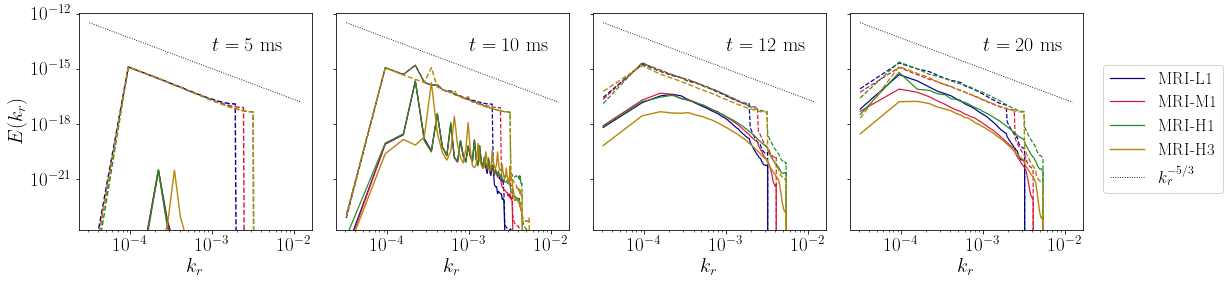

In [7]:
fig, ax = plt.subplots(1,4,sharex = 'all', sharey = 'all', figsize=(18,4))

for i in range(0,4):
    ax[i].tick_params(axis='y',labelsize = 19)
    ax[i].tick_params(axis='x',labelsize = 19)
        
plt.subplots_adjust(wspace = 0.1) 

ax[0].plot(k240[:-1], emag240[1,:-1], color = 'darkblue', linewidth = '1.4', linestyle = 'solid', label = 'MRI-L1')
ax[0].plot(k240[:-1], ekin240[1,:-1], color = 'darkblue', linewidth = '1.4', linestyle = 'dashed')
ax[0].plot(k400[:-1], k400[:-1]**(-5/3)*1e-20, color = 'black', linewidth = '0.9', linestyle = 'dotted', label = r'$k^{-5/3}$')
ax[0].plot(k304[:-1], emag304[1,:-1], color = 'crimson', linewidth = '1.4', linestyle = 'solid',label = 'MRI-M1')
ax[0].plot(k304[:-1], ekin304[1,:-1], color = 'crimson', linewidth = '1.4', linestyle = 'dashed')
ax[0].plot(k400[:-1], emag400[1,:-1], color = 'forestgreen', linewidth = '1.4', linestyle = 'solid', label = 'MRI-H1')
ax[0].plot(k400[:-1], ekin400[1,:-1], color = 'forestgreen', linewidth = '1.4', linestyle = 'dashed')
ax[0].plot(k400b[:-1], emag400b[1,:-1], color = 'darkgoldenrod', linewidth = '1.4', linestyle = 'solid', label = 'MRI-H3')
ax[0].plot(k400b[:-1], ekin400b[1,:-1], color = 'darkgoldenrod', linewidth = '1.4', linestyle = 'dashed')
ax[0].set_ylabel(r'$E(k_r)$', fontsize = 20)
ax[0].set_xlabel(r'$k_r$', fontsize = 20)
#ax[0].set_xlim(left = 7e-5)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(1e-3,1e-14,r'$t='+str(t[1])+'$ ms', fontsize = 20)

ax[1].plot(k240[:-1], emag240[2,:-1], color = 'darkblue', linewidth = '1.2', linestyle = 'solid', label = 'MRI-L1')
ax[1].plot(k240[:-1], ekin240[2,:-1], color = 'darkblue', linewidth = '1.2', linestyle = 'dashed')
ax[1].plot(k400[:-1], k400[:-1]**(-5/3)*1e-20, color = 'black', linewidth = '0.9', linestyle = 'dotted', label = r'$k^{-5/3}$')
ax[1].plot(k304[:-1], emag304[2,:-1], color = 'crimson', linewidth = '1.2', linestyle = 'solid', label = 'MRI-M1')
ax[1].plot(k304[:-1], ekin304[2,:-1], color = 'crimson', linewidth = '1.2', linestyle = 'dashed')
ax[1].plot(k400[:-1], emag400[2,:-1], color = 'forestgreen', linewidth = '1.2', linestyle = 'solid', label = 'MRI-H1')
ax[1].plot(k400[:-1], ekin400[2,:-1], color = 'forestgreen', linewidth = '1.2', linestyle = 'dashed')
ax[1].plot(k400b[:-1], emag400b[2,:-1], color = 'darkgoldenrod', linewidth = '1.4', linestyle = 'solid', label = 'MRI-H3')
ax[1].plot(k400b[:-1], ekin400b[2,:-1], color = 'darkgoldenrod', linewidth = '1.4', linestyle = 'dashed')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$k_r$', fontsize = 20)
ax[1].text(1e-3,1e-14,r'$t='+str(t[2])+'$ ms', fontsize = 20)

ax[2].plot(k240[:-1], emag240[4,:-1], color = 'darkblue', linewidth = '1.2', linestyle = 'solid', label = 'MRI-L1')
ax[2].plot(k240[:-1], ekin240[4,:-1], color = 'darkblue', linewidth = '1.2', linestyle = 'dashed')
ax[2].plot(k400[:-1], k400[:-1]**(-5/3)*1e-20, color = 'black', linewidth = '0.9', linestyle = 'dotted', label = r'$k^{-5/3}$')
ax[2].plot(k304[:-1], emag304[4,:-1], color = 'crimson', linewidth = '1.2', linestyle = 'solid', label = 'MRI-M1')
ax[2].plot(k304[:-1], ekin304[4,:-1], color = 'crimson', linewidth = '1.2', linestyle = 'dashed')
ax[2].plot(k400[:-1], emag400[4,:-1], color = 'forestgreen', linewidth = '1.2', linestyle = 'solid', label = 'MRI-H1')
ax[2].plot(k400[:-1], ekin400[4,:-1], color = 'forestgreen', linewidth = '1.2', linestyle = 'dashed')
ax[2].plot(k400b[:-1], emag400b[4,:-1], color = 'darkgoldenrod', linewidth = '1.4', linestyle = 'solid', label = 'MRI-H3')
ax[2].plot(k400b[:-1], ekin400b[4,:-1], color = 'darkgoldenrod', linewidth = '1.4', linestyle = 'dashed')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$k_r$', fontsize = 20)
ax[2].text(1e-3,1e-14,r'$t='+str(t[4])+'$ ms', fontsize = 20)

ax[3].plot(k240[:-1], emag240[7,:-1], color = 'darkblue', linewidth = '1.2', linestyle = 'solid', label = 'MRI-L1')
ax[3].plot(k240[:-1], ekin240[7,:-1], color = 'darkblue', linewidth = '1.2', linestyle = 'dashed')
ax[3].plot(k304[:-1], emag304[7,:-1], color = 'crimson', linewidth = '1.2', linestyle = 'solid', label = 'MRI-M1')
ax[3].plot(k304[:-1], ekin304[7,:-1], color = 'crimson', linewidth = '1.2', linestyle = 'dashed')
ax[3].plot(k400[:-1], emag400[7,:-1], color = 'forestgreen', linewidth = '1.2', linestyle = 'solid', label = 'MRI-H1')
ax[3].plot(k400[:-1], ekin400[7,:-1], color = 'forestgreen', linewidth = '1.2', linestyle = 'dashed')
ax[3].plot(k400b[:-1], emag400b[7,:-1], color = 'darkgoldenrod', linewidth = '1.4', linestyle = 'solid', label = 'MRI-H3')
ax[3].plot(k400b[:-1], ekin400b[7,:-1], color = 'darkgoldenrod', linewidth = '1.4', linestyle = 'dashed')
ax[3].plot(k400[:-1], k400[:-1]**(-5/3)*1e-20, color = 'black', linewidth = '0.9', linestyle = 'dotted', label = r'$k_r^{-5/3}$')
ax[3].set_yscale('log')
ax[3].set_xlabel(r'$k_r$', fontsize = 20)
ax[3].text(1e-3,1e-14,r'$t='+str(t[7])+'$ ms', fontsize = 20)
ax[3].legend(bbox_to_anchor = (1.05,0.8), fontsize = 17)
#plt.savefig('/home/miquelmiravet/Desktop/figs_mri/mri_spectra_test.pdf',bbox_inches = 'tight')

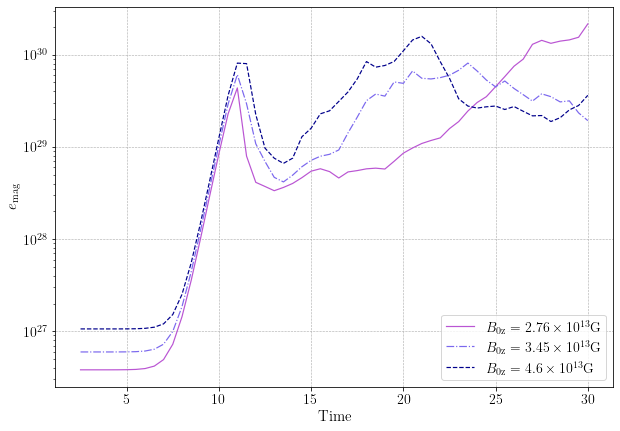

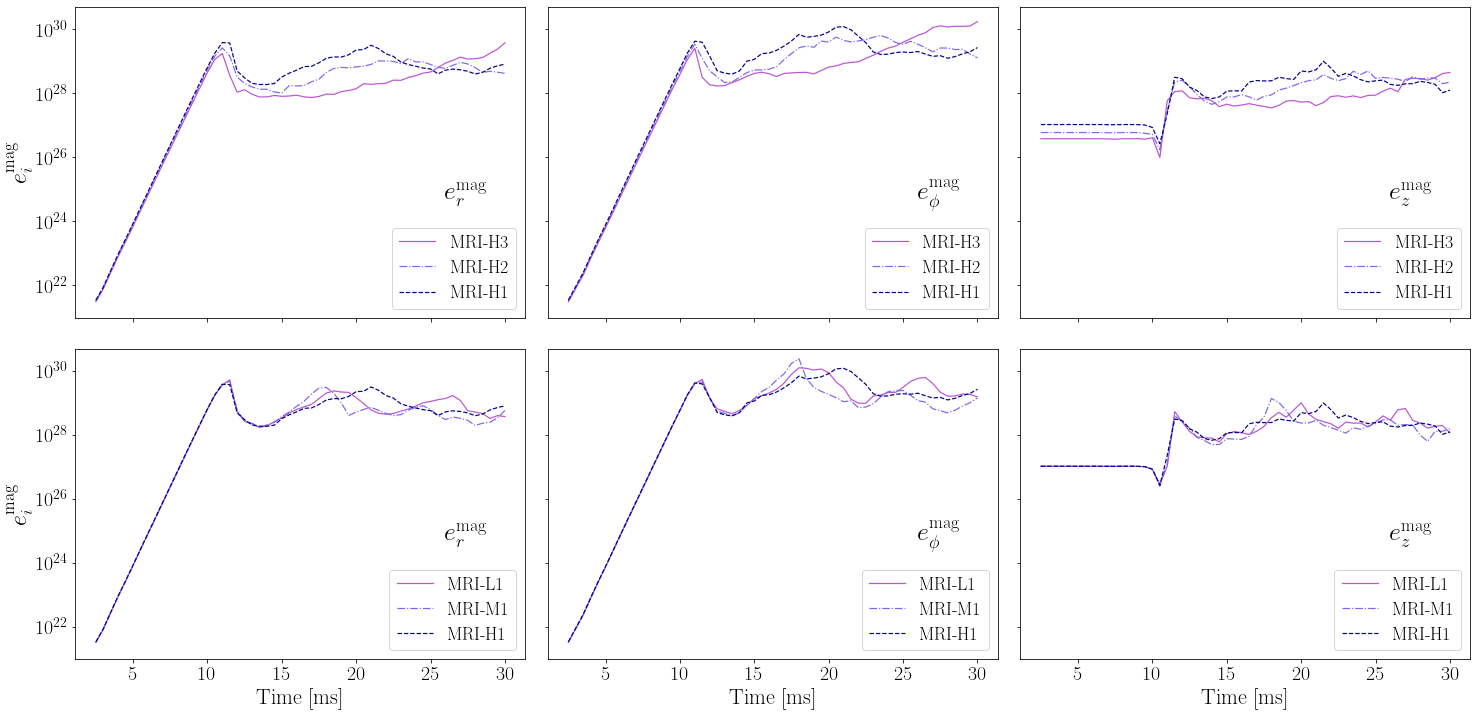

In [9]:
#plots magnetic energy
t = np.linspace(0,30,61)

fig, ax = plt.subplots(figsize = (10,7),sharex='all',sharey='all')

ax.tick_params(axis='y',labelsize = 14)
ax.tick_params(axis='x',labelsize = 14)

ax.plot(t[5:],energ_blow[5:,0], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax.plot(t[5:],energ_bmed[5:,0], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax.plot(t[5:],energ_bhigh[5:,0], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax.set_ylabel(r'$e_{\rm mag}$', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_yscale('log')
ax.grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax.set_xscale('log')
ax.legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_energy_mag_400.pdf',bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(2,3,sharex = 'all',sharey='all',figsize = (25,12))

plt.subplots_adjust(hspace = 0.1) 
plt.subplots_adjust(wspace = 0.05) 

for i in range(0,2):
    for j in range(0,3):
        ax[i,j].tick_params(axis='y',labelsize = 20)
        ax[i,j].tick_params(axis='x',labelsize = 20)

ax[0,0].plot(t[5:],energ_blow[5:,1], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'MRI-H3')
ax[0,0].plot(t[5:],energ_bmed[5:,1], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'MRI-H2')
ax[0,0].plot(t[5:],energ_bhigh[5:,1], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'MRI-H1')

ax[0,0].text(26,5e24,r'$e^{\rm mag}_{r}$', fontsize = 26)
ax[0,0].set_ylabel(r'$e^{\rm mag}_i$', fontsize = 24)
#ax[0,0].set_xlabel('Time', fontsize = 15)
ax[0,0].set_yscale('log')
ax[0,0].set_ylim([1e21,5e30])
#ax[0,0].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[0].set_xscale('log')
ax[0,0].legend(loc = 'lower right', fontsize = 18)

ax[0,1].plot(t[5:],energ_blow[5:,2], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'MRI-H3')
ax[0,1].plot(t[5:],energ_bmed[5:,2], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'MRI-H2')
ax[0,1].plot(t[5:],energ_bhigh[5:,2], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'MRI-H1')

ax[0,1].text(26,5e24,r'$e^{\rm mag}_{\rm \phi}$', fontsize = 26)
#ax[0,1].set_xlabel('Time', fontsize = 15)
ax[0,1].set_yscale('log')
#ax[0,1].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[1].set_xscale('log')
ax[0,1].legend(loc = 'lower right', fontsize = 18)

ax[0,2].plot(t[5:],energ_blow[5:,3], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'MRI-H3')
ax[0,2].plot(t[5:],energ_bmed[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'MRI-H2')
ax[0,2].plot(t[5:],energ_bhigh[5:,3], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'MRI-H1')

ax[0,2].text(26,5e24,r'$e^{\rm mag}_{z}$', fontsize = 26)
#ax[0,2].set_xlabel('Time', fontsize = 15)
ax[0,2].set_yscale('log')
#ax[0,2].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[2].set_xscale('log')
ax[0,2].legend(loc = 'lower right', fontsize = 18)

ax[1,0].plot(t[5:],energ_rlow[5:,1], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'MRI-L1')
ax[1,0].plot(t[5:],energ_rmed[5:,1], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'MRI-M1')
ax[1,0].plot(t[5:],energ_bhigh[5:,1], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'MRI-H1')

ax[1,0].set_ylabel(r'$e^{\rm mag}_i$', fontsize = 24)
ax[1,0].set_xlabel('Time [ms]', fontsize = 22)
ax[1,0].text(26,5e24,r'$e^{\rm mag}_{r}$', fontsize = 26)
ax[1,0].set_yscale('log')
#ax[1,0].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[0].set_xscale('log')
ax[1,0].legend(loc = 'lower right', fontsize = 18)

ax[1,1].plot(t[5:],energ_rlow[5:,2], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'MRI-L1')
ax[1,1].plot(t[5:],energ_rmed[5:,2], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'MRI-M1')
ax[1,1].plot(t[5:],energ_bhigh[5:,2], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'MRI-H1')

ax[1,1].set_xlabel('Time [ms]', fontsize = 22)
ax[1,1].text(26,5e24,r'$e^{\rm mag}_{\rm \phi}$', fontsize = 26)
ax[1,1].set_yscale('log')
#ax[1,1].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[1].set_xscale('log')
ax[1,1].legend(loc = 'lower right', fontsize = 18)

ax[1,2].plot(t[5:],energ_rlow[5:,3], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'MRI-L1')
ax[1,2].plot(t[5:],energ_rmed[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'MRI-M1')
ax[1,2].plot(t[5:],energ_bhigh[5:,3], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'MRI-H1')

ax[1,2].set_xlabel('Time [ms]', fontsize = 22)
ax[1,2].text(26,5e24,r'$e^{\rm mag}_{z}$', fontsize = 26)
ax[1,2].set_yscale('log')
#ax[1,2].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[2].set_xscale('log')
ax[1,2].legend(loc = 'lower right', fontsize = 18)

#plt.savefig('/home/miquelmiravet/Desktop/figs_mri/mri_energy_mag_comp.pdf',bbox_inches = 'tight')
plt.show()

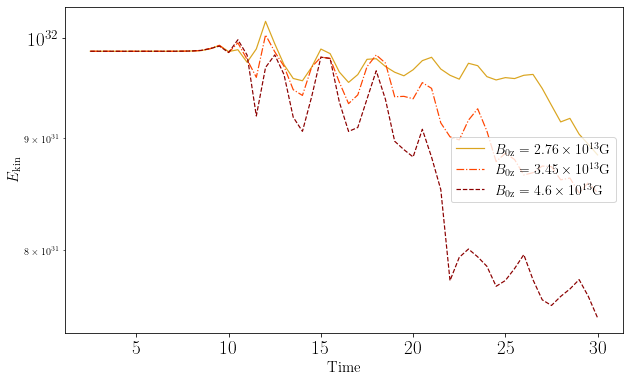

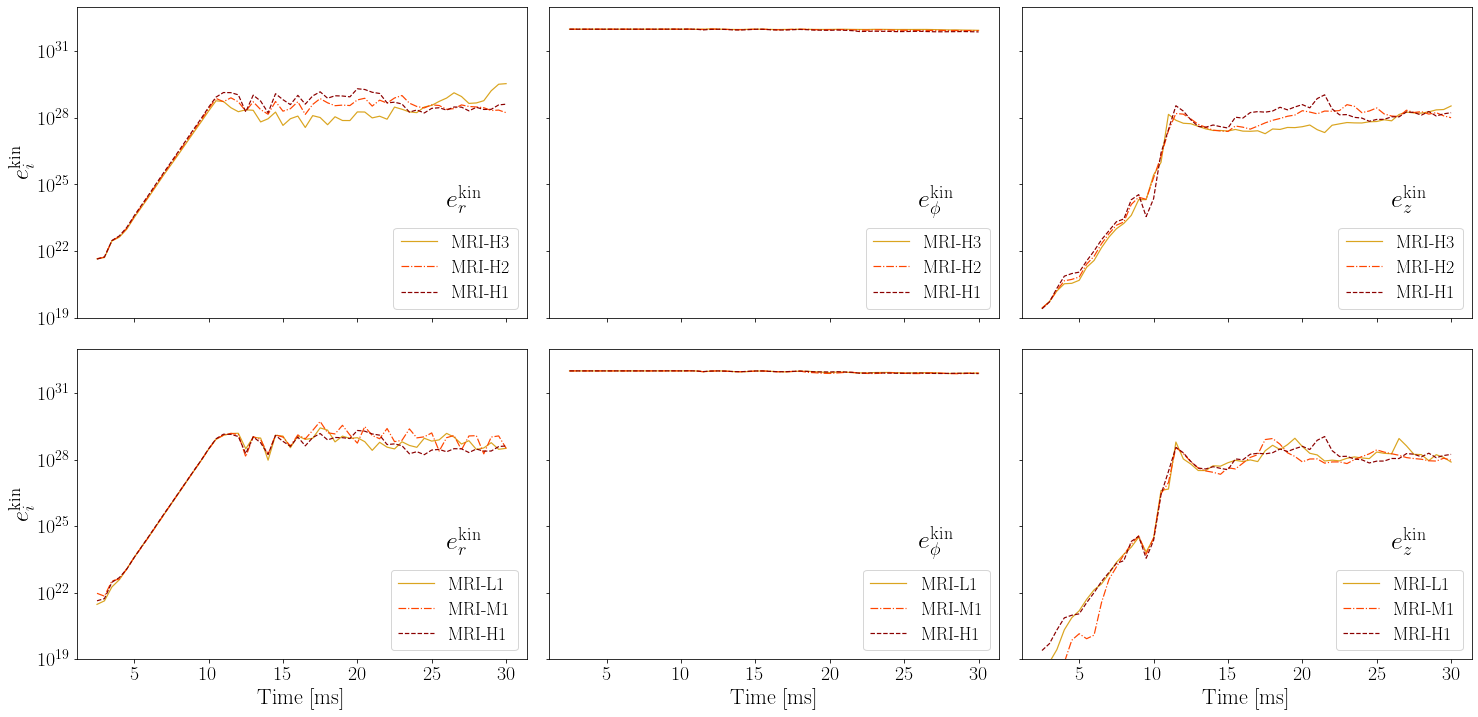

In [10]:
#plots kinetic energy

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(axis='y',labelsize = 19)
ax.tick_params(axis='x',labelsize = 19)

ax.plot(t[5:],energ_blow[5:,4], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax.plot(t[5:],energ_bmed[5:,4], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax.plot(t[5:],energ_bhigh[5:,4], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax.set_ylabel(r'$E_{\rm kin}$', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_yscale('log')
ax.legend(loc = 'center right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_energy_kin_400.pdf',bbox_inches = 'tight')

plt.show()

fig, ax = plt.subplots(2,3,sharex = 'all',sharey='all',figsize = (25,12))

plt.subplots_adjust(hspace = 0.1) 
plt.subplots_adjust(wspace = 0.05) 

for i in range(0,2):
    for j in range(0,3):
        ax[i,j].tick_params(axis='y',labelsize = 20)
        ax[i,j].tick_params(axis='x',labelsize = 20)

ax[0,0].plot(t[5:],energ_blow[5:,5], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'MRI-H3')
ax[0,0].plot(t[5:],energ_bmed[5:,5], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'MRI-H2')
ax[0,0].plot(t[5:],energ_bhigh[5:,5], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'MRI-H1')

ax[0,0].text(26,1e24,r'$e^{\rm kin}_{ r}$', fontsize = 26)
ax[0,0].set_ylabel(r'$e^{\rm kin}_i$', fontsize = 24)
#ax[0,0].set_xlabel('Time', fontsize = 15)
ax[0,0].set_yscale('log')
ax[0,0].set_ylim([1e19,1e33])
#ax[0,0].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[0].set_xscale('log')
ax[0,0].legend(loc = 'lower right', fontsize = 18)

ax[0,1].plot(t[5:],energ_blow[5:,6], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'MRI-H3')
ax[0,1].plot(t[5:],energ_bmed[5:,6], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'MRI-H2')
ax[0,1].plot(t[5:],energ_bhigh[5:,6], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'MRI-H1')

ax[0,1].text(26,1e24,r'$e^{\rm kin}_{\rm \phi}$', fontsize = 26)
#ax[0,1].set_xlabel('Time', fontsize = 15)
ax[0,1].set_yscale('log')
#ax[0,1].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[1].set_xscale('log')
ax[0,1].legend(loc = 'lower right', fontsize = 18)

ax[0,2].plot(t[5:],energ_blow[5:,7], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'MRI-H3')
ax[0,2].plot(t[5:],energ_bmed[5:,7], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'MRI-H2')
ax[0,2].plot(t[5:],energ_bhigh[5:,7], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'MRI-H1')

ax[0,2].text(26,1e24,r'$e^{\rm kin}_{z}$', fontsize = 26)
#ax[0,2].set_xlabel('Time', fontsize = 15)
ax[0,2].set_yscale('log')
#ax[0,2].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[2].set_xscale('log')
ax[0,2].legend(loc = 'lower right', fontsize = 18)

ax[1,0].plot(t[5:],energ_rlow[5:,5], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'MRI-L1')
ax[1,0].plot(t[5:],energ_rmed[5:,5], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'MRI-M1')
ax[1,0].plot(t[5:],energ_bhigh[5:,5], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'MRI-H1')

ax[1,0].set_ylabel(r'$e^{\rm kin}_i$', fontsize = 24)
ax[1,0].set_xlabel('Time [ms]', fontsize = 22)
ax[1,0].text(26,1e24,r'$e^{\rm kin}_{r}$', fontsize = 26)
ax[1,0].set_yscale('log')
#ax[1,0].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[0].set_xscale('log')
ax[1,0].legend(loc = 'lower right', fontsize = 18)

ax[1,1].plot(t[5:],energ_rlow[5:,6], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'MRI-L1')
ax[1,1].plot(t[5:],energ_rmed[5:,6], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'MRI-M1')
ax[1,1].plot(t[5:],energ_bhigh[5:,6], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'MRI-H1')

ax[1,1].set_xlabel('Time [ms]', fontsize = 22)
ax[1,1].text(26,1e24,r'$e^{\rm kin}_{\rm \phi}$', fontsize = 26)
ax[1,1].set_yscale('log')
#ax[1,1].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[1].set_xscale('log')
ax[1,1].legend(loc = 'lower right', fontsize = 18)

ax[1,2].plot(t[5:],energ_rlow[5:,7], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'MRI-L1')
ax[1,2].plot(t[5:],energ_rmed[5:,7], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'MRI-M1')
ax[1,2].plot(t[5:],energ_bhigh[5:,7], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'MRI-H1')

ax[1,2].set_xlabel('Time [ms]', fontsize = 22)
ax[1,2].text(26,1e24,r'$e^{\rm kin}_{z}$', fontsize = 26)
ax[1,2].set_yscale('log')
#ax[1,2].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[2].set_xscale('log')
ax[1,2].legend(loc = 'lower right', fontsize = 18)

#plt.savefig('/home/miquelmiravet/Desktop/figs_mri/mri_energy_kin_comp.pdf',bbox_inches = 'tight')

plt.show()

In [11]:
path_mri = '/media/miquelmiravet/Maxtor1/MRI'
path_blow = path_mri+'/A100_400_100_B_2.76/'
path_bmed = path_mri+'/A100_400_100_B_3.45/'
path_bhigh = path_mri+'/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil/'

t = np.linspace(0,30,61)

energ_blow = np.zeros((len(t),8))
energ_bhigh = np.zeros((len(t),8))
energ_bmed = np.zeros((len(t),8))

print('Dimensions of the grid : 100x400x100')

print('LOW MAGNETIC FIELD: b_0z = 2.76e13 G')
for i in range(0,len(t)):
    arx = format(25*i, "08")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_blow+'/outp-mri/mri'+str(arx)+'.h5')
    print('Time           : ',t[i])
    
    b = np.array([Br,Bphi,Bz])
    v = np.array([vr,vphi,vz])
    
    energ_blow[i] = energies_vol(r,phi,z,b,v,rho)
    
print('MEDIUM MAGNETIC FIELD: b_0z = 3.45e13 G')
for i in range(0,len(t)):
    arx = format(25*i, "08")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_bmed+'/outp-mri/mri'+str(arx)+'.h5')
    print('Time           : ',t[i])
    
    b = np.array([Br,Bphi,Bz])
    v = np.array([vr,vphi,vz])
    
    energ_bmed[i] = energies_vol(r,phi,z,b,v,rho)
    
print('HIGH MAGNETIC FIELD: b_0z = 4.6e13 G')
for i in range(0,len(t)):
    arx = format(25*i, "04")
    r,phi,z,Br, Bphi, Bz, vr, vphi, vz,rho = readh5files(path_bhigh+'/mri-'+str(arx)+'.h5')    
    print('Time           : ',t[i])
    
    b = np.array([Br,Bphi,Bz])
    v = np.array([vr,vphi,vz])
    
    energ_bhigh[i] = energies_vol(r,phi,z,b,v,rho)  

Dimensions of the grid : 100x400x100
LOW MAGNETIC FIELD: b_0z = 2.76e13 G
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000000.h5
Time           :  0.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000025.h5
Time           :  0.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000050.h5
Time           :  1.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000075.h5
Time           :  1.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000100.h5
Time           :  2.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000125.h5
Time           :  2.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.76//outp-mri/mri00000150.h5
Time           :  3.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_2.

DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_3.45//outp-mri/mri00000125.h5
Time           :  2.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_3.45//outp-mri/mri00000150.h5
Time           :  3.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_3.45//outp-mri/mri00000175.h5
Time           :  3.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_3.45//outp-mri/mri00000200.h5
Time           :  4.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_3.45//outp-mri/mri00000225.h5
Time           :  4.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_3.45//outp-mri/mri00000250.h5
Time           :  5.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_3.45//outp-mri/mri00000275.h5
Time           :  5.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_3.45//outp-mri/mri00000300.h5
Time           :  6.0
DATA FROM FILE:       /m

Time           :  4.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0225.h5
Time           :  4.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0250.h5
Time           :  5.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0275.h5
Time           :  5.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0300.h5
Time           :  6.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0325.h5
Time           :  6.5
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.6e13_v_4.45d8_r_4.45d8_Lz_1.0_INTEL_stencil//mri-0350.h5
Time           :  7.0
DATA FROM FILE:       /media/miquelmiravet/Maxtor1/MRI/A100_400_100_B_4.

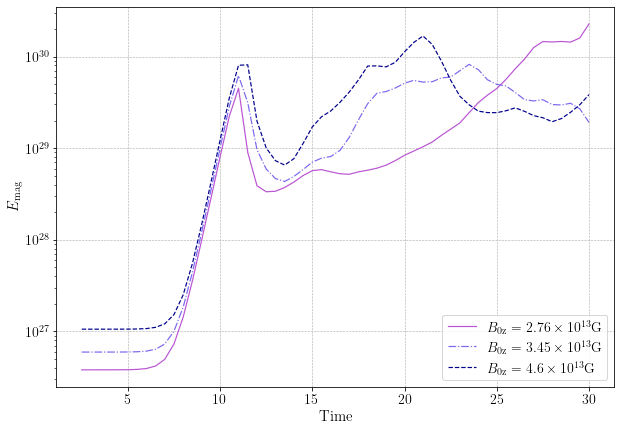

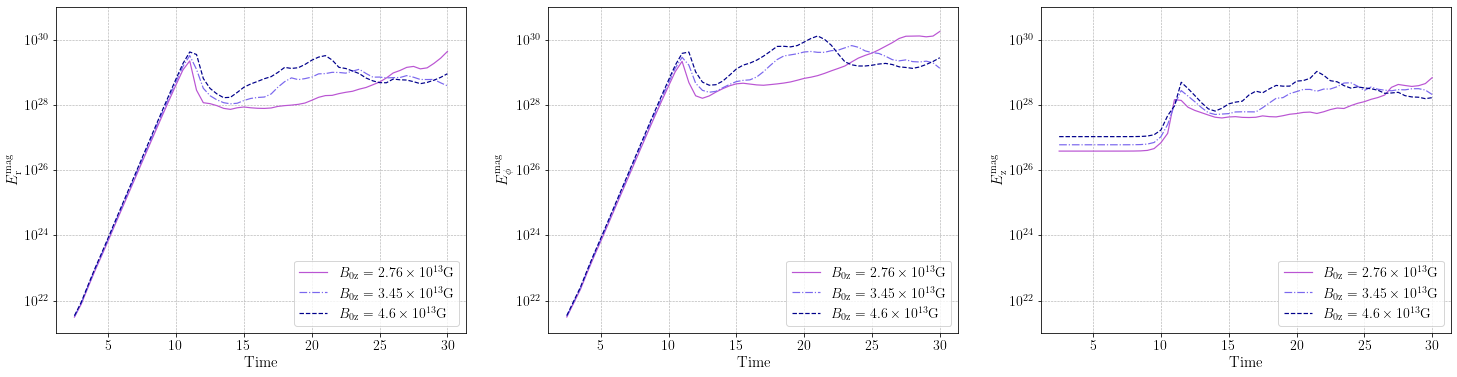

In [13]:
#plots magnetic energy

fig, ax = plt.subplots(figsize = (10,7))

ax.tick_params(axis='y',labelsize = 14)
ax.tick_params(axis='x',labelsize = 14)

ax.plot(t[5:],energ_blow[5:,0], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax.plot(t[5:],energ_bmed[5:,0], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax.plot(t[5:],energ_bhigh[5:,0], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax.set_ylabel(r'$E_{\rm mag}$', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_yscale('log')
ax.grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax.set_xscale('log')
ax.legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_energy_mag_vol_400.pdf',bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(1,3,sharex = 'all',figsize = (25,6))

for i in range(0,3):
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].tick_params(axis='x',labelsize = 14)

ax[0].plot(t[5:],energ_blow[5:,1], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],energ_bmed[5:,1], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],energ_bhigh[5:,1], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax[0].set_ylabel(r'$E^{\rm mag}_{\rm r}$', fontsize = 15)
ax[0].set_xlabel('Time', fontsize = 15)
ax[0].set_yscale('log')
ax[0].set_ylim([1e21,1e31])
ax[0].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[0].set_xscale('log')
ax[0].legend(loc = 'lower right', fontsize = 14)

ax[1].plot(t[5:],energ_blow[5:,2], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],energ_bmed[5:,2], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],energ_bhigh[5:,2], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax[1].set_ylabel(r'$E^{\rm mag}_{\rm \phi}$', fontsize = 15)
ax[1].set_xlabel('Time', fontsize = 15)
ax[1].set_yscale('log')
ax[1].set_ylim([1e21,1e31])
ax[1].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[1].set_xscale('log')
ax[1].legend(loc = 'lower right', fontsize = 14)

ax[2].plot(t[5:],energ_blow[5:,3], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],energ_bmed[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],energ_bhigh[5:,3], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax[2].set_ylabel(r'$E^{\rm mag}_{\rm z}$', fontsize = 15)
ax[2].set_xlabel('Time', fontsize = 15)
ax[2].set_yscale('log')
ax[2].set_ylim([1e21,1e31])
ax[2].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax[2].set_xscale('log')
ax[2].legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_energy_mag_comp__vol_400.pdf',bbox_inches = 'tight')
plt.show()

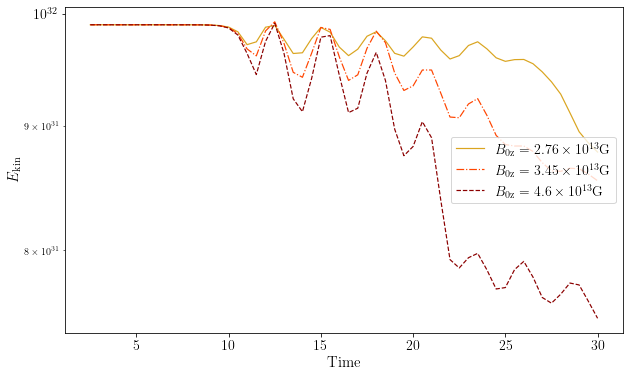

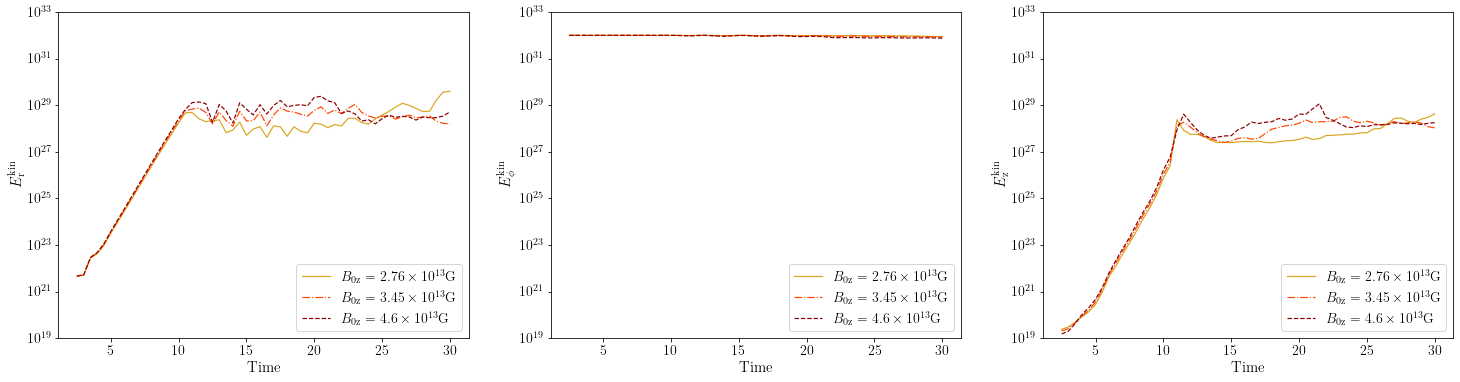

In [59]:
#plots kinetic energy

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(axis='y',labelsize = 14)
ax.tick_params(axis='x',labelsize = 14)

ax.plot(t[5:],energ_blow[5:,4], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax.plot(t[5:],energ_bmed[5:,4], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax.plot(t[5:],energ_bhigh[5:,4], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax.set_ylabel(r'$E_{\rm kin}$', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_yscale('log')
ax.legend(loc = 'center right', fontsize = 14)

plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_energy_kin_vol_400.pdf',bbox_inches = 'tight')

plt.show()

fig, ax = plt.subplots(1,3,sharex = 'all',figsize = (25,6))

for i in range(0,3):
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].tick_params(axis='x',labelsize = 14)

ax[0].plot(t[5:],energ_blow[5:,5], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],energ_bmed[5:,5], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],energ_bhigh[5:,5], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax[0].set_ylabel(r'$E^{\rm kin}_{\rm r}$', fontsize = 15)
ax[0].set_xlabel('Time', fontsize = 15)
ax[0].set_yscale('log')
ax[0].set_ylim([1e19,1e33])
ax[0].legend(loc = 'lower right', fontsize = 14)

ax[1].plot(t[5:],energ_blow[5:,6], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],energ_bmed[5:,6], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],energ_bhigh[5:,6], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax[1].set_ylabel(r'$E^{\rm kin}_{\rm \phi}$', fontsize = 15)
ax[1].set_xlabel('Time', fontsize = 15)
ax[1].set_yscale('log')
ax[1].set_ylim([1e19,1e33])
ax[1].legend(loc = 'lower right', fontsize = 14)

ax[2].plot(t[5:],energ_blow[5:,7], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],energ_bmed[5:,7], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],energ_bhigh[5:,7], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax[2].set_ylabel(r'$E^{\rm kin}_{\rm z}$', fontsize = 15)
ax[2].set_xlabel('Time', fontsize = 15)
ax[2].set_yscale('log')
ax[2].set_ylim([1e19,1e33])
ax[2].legend(loc = 'lower right', fontsize = 14)

plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_energy_kin_comp_vol_400.pdf',bbox_inches = 'tight')

plt.show()

In [4]:
#plots stresses
t = np.linspace(0,30,61)

path_stresses = '/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/'
path_blow = path_stresses+'surface_av/b0z-2.76e13'
path_bhigh = path_stresses+'surface_av/b0z-3.45e13'
path_bmed = path_stresses+'surface_av/b0z-4.6e13'


M1 = np.zeros((len(t),6))
R1 = np.zeros((len(t),6))
F1 = np.zeros((len(t),3))
eT1 = np.zeros(len(t))
rho1 = np.zeros(len(t))

M2 = np.zeros((len(t),6))
R2 = np.zeros((len(t),6))
F2 = np.zeros((len(t),3))
eT2 = np.zeros(len(t))
rho2 = np.zeros(len(t))

M3 = np.zeros((len(t),6))
R3 = np.zeros((len(t),6))
F3 = np.zeros((len(t),3))
eT3 = np.zeros(len(t))
rho3 = np.zeros(len(t))

for tt in range(0, len(t)):

    arx = format(25*tt, "04")
    M1[tt], R1[tt], F1[tt], eT1[tt], rho1[tt] = readstresses(path_blow+'/stresses_sigma_r0-'+arx+'.h5')
    M2[tt], R2[tt], F2[tt], eT2[tt], rho2[tt] = readstresses(path_bhigh+'/stresses_sigma_r0-'+arx+'.h5')
    M3[tt], R3[tt], F3[tt], eT3[tt], rho3[tt] = readstresses(path_bmed+'/stresses_sigma_r0-'+arx+'.h5')

M1trace = M1[:,0]+M1[:,3]+M1[:,5]
M2trace = M2[:,0]+M2[:,3]+M2[:,5]
M3trace = M3[:,0]+M3[:,3]+M3[:,5]
R1trace = R1[:,0]+R1[:,3]+R1[:,5]
R2trace = R2[:,0]+R2[:,3]+R2[:,5]
R3trace = R3[:,0]+R3[:,3]+R3[:,5]

for i in range(0,6):
    R1[:,i] = R1[:,i]*rho1[:]
    R2[:,i] = R2[:,i]*rho2[:]
    R3[:,i] = R3[:,i]*rho3[:]
    
R1trace[:] = R1trace[:]*rho1[:]
R2trace[:] = R2trace[:]*rho2[:]
R3trace[:] = R3trace[:]*rho3[:]


for i in range(0,3):
    F1[:,i] = (F1[:,i]*rho1**(0.5))
    F2[:,i] = (F2[:,i]*rho2**(0.5))
    F3[:,i] = (F3[:,i]*rho3**(0.5))

DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/surface_av/b0z-2.76e13/stresses_sigma_r0-0000.h5
Keys: <KeysViewHDF5 ['F9mean', 'Fmean', 'Mmean', 'Rmean', 'r0', 'rhomean', 'sigma_F', 'sigma_F9', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
F9mean
Fmean
Mmean
Rmean
r0
rhomean
sigma_F
sigma_F9
sigma_M
sigma_R
sigma_rho
time
Time           : 0.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/surface_av/b0z-3.45e13/stresses_sigma_r0-0000.h5
Keys: <KeysViewHDF5 ['F9mean', 'Fmean', 'Mmean', 'Rmean', 'r0', 'rhomean', 'sigma_F', 'sigma_F9', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
F9mean
Fmean
Mmean
Rmean
r0
rhomean
sigma_F
sigma_F9
sigma_M
sigma_R
sigma_rho
time
Time           : 0.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tens

F9mean
Fmean
Mmean
Rmean
r0
rhomean
sigma_F
sigma_F9
sigma_M
sigma_R
sigma_rho
time
Time           : 4.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/surface_av/b0z-4.6e13/stresses_sigma_r0-0200.h5
Keys: <KeysViewHDF5 ['F9mean', 'Fmean', 'Mmean', 'Rmean', 'r0', 'rhomean', 'sigma_F', 'sigma_F9', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
F9mean
Fmean
Mmean
Rmean
r0
rhomean
sigma_F
sigma_F9
sigma_M
sigma_R
sigma_rho
time
Time           : 4.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/surface_av/b0z-2.76e13/stresses_sigma_r0-0225.h5
Keys: <KeysViewHDF5 ['F9mean', 'Fmean', 'Mmean', 'Rmean', 'r0', 'rhomean', 'sigma_F', 'sigma_F9', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
F9mean
Fmean
Mmean
Rmean
r0
rhomean
sigma_F
sigma_F9
sigma_M
sigma_R
sigma_rho
time
Time           : 4.5  ms
DATA FROM 

Keys: <KeysViewHDF5 ['F9mean', 'Fmean', 'Mmean', 'Rmean', 'r0', 'rhomean', 'sigma_F', 'sigma_F9', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
F9mean
Fmean
Mmean
Rmean
r0
rhomean
sigma_F
sigma_F9
sigma_M
sigma_R
sigma_rho
time
Time           : 22.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/surface_av/b0z-4.6e13/stresses_sigma_r0-1100.h5
Keys: <KeysViewHDF5 ['F9mean', 'Fmean', 'Mmean', 'Rmean', 'r0', 'rhomean', 'sigma_F', 'sigma_F9', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
F9mean
Fmean
Mmean
Rmean
r0
rhomean
sigma_F
sigma_F9
sigma_M
sigma_R
sigma_rho
time
Time           : 22.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/surface_av/b0z-2.76e13/stresses_sigma_r0-1125.h5
Keys: <KeysViewHDF5 ['F9mean', 'Fmean', 'Mmean', 'Rmean', 'r0', 'rhomean', 'sigma_F', 'sigma_F9', 'sigma_M', 'sigma_R

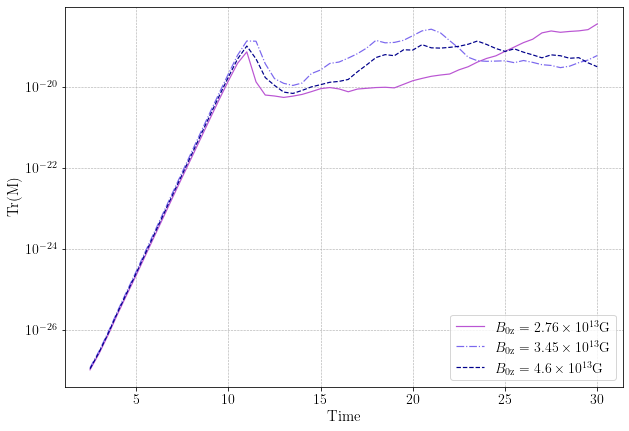

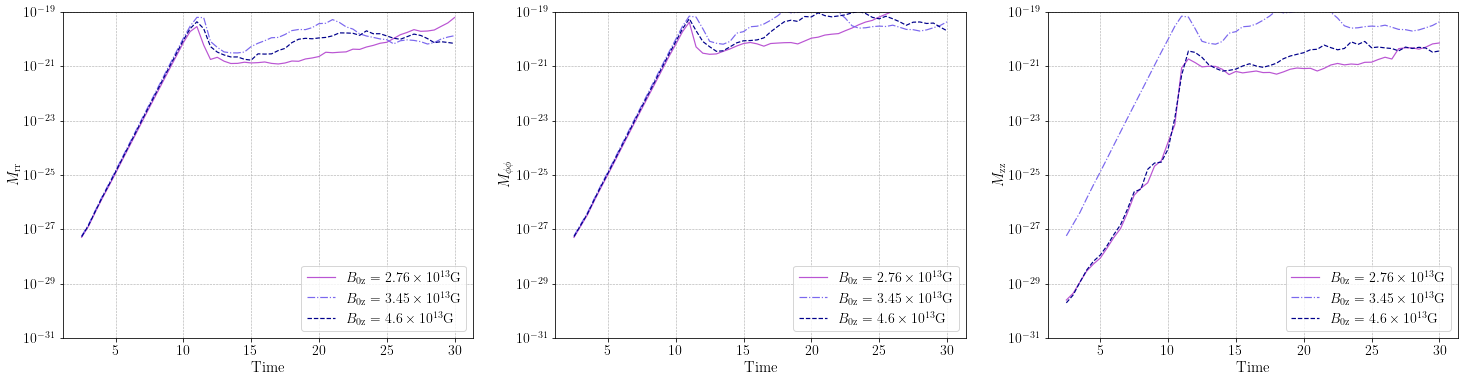

In [5]:
#plots maxwell

fig, ax = plt.subplots(figsize = (10,7))

ax.tick_params(axis='y',labelsize = 14)
ax.tick_params(axis='x',labelsize = 14)

ax.plot(t[5:],M1trace[5:], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax.plot(t[5:],M3trace[5:], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax.plot(t[5:],M2trace[5:], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax.set_ylabel(r'$\rm{Tr}(M)$', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_yscale('log')
ax.grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax.set_xscale('log')
ax.legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_trace_maxwell_400.pdf',bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(1,3,sharex = 'all', sharey = 'none', figsize = (25,6))

for i in range(0,3):
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].tick_params(axis='x',labelsize = 14)
    
plt.subplots_adjust(wspace = 0.2) 

ax[0].plot(t[5:],M1[5:,0], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],M3[5:,0], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],M2[5:,0], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax[0].set_yscale('log')
ax[0].set_ylim([1e-31,1e-19])
ax[0].set_ylabel(r'$M_{\rm rr}$', fontsize = 15)
ax[0].set_xlabel('Time', fontsize = 15)
ax[0].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
ax[0].legend(loc = 'lower right', fontsize = 14)

ax[1].plot(t[5:],M1[5:,3], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],M3[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],M2[5:,3], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[1].set_yscale('log')
ax[1].set_ylim([1e-31,1e-19])
ax[1].set_ylabel(r'$M_{\rm \phi\phi}$', fontsize = 15)
ax[1].set_xlabel('Time', fontsize = 15)
ax[1].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
ax[1].legend(loc = 'lower right', fontsize = 14)

ax[2].plot(t[5:],M1[5:,5], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],M3[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],M2[5:,5], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[2].set_yscale('log')
ax[2].set_ylim([1e-31,1e-19])
ax[2].set_ylabel(r'$M_{\rm zz}$', fontsize = 15)
ax[2].set_xlabel('Time', fontsize = 15)
ax[2].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
ax[2].legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_maxwell_comp_400.pdf',bbox_inches = 'tight')
plt.show()

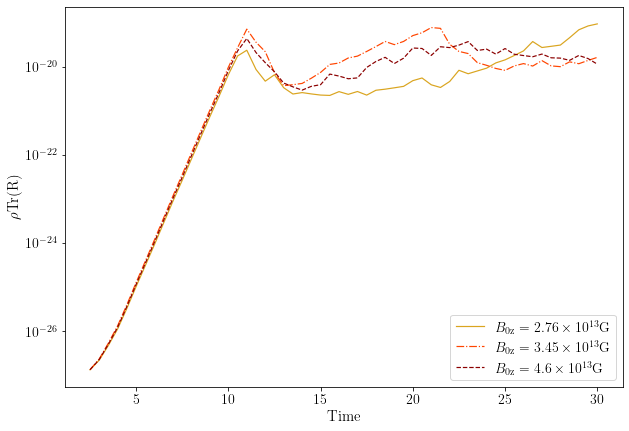

In [6]:
#plots reynolds

for i in range(0,6):
    R1[:,i] = R1[:,i]*rho1[:]
    R2[:,i] = R2[:,i]*rho2[:]
    R3[:,i] = R3[:,i]*rho3[:]
    
R1trace[:] = R1trace[:]*rho1[:]
R2trace[:] = R2trace[:]*rho2[:]
R3trace[:] = R3trace[:]*rho3[:]


fig, ax = plt.subplots(figsize = (10,7))

ax.tick_params(axis='y',labelsize = 14)
ax.tick_params(axis='x',labelsize = 14)

ax.plot(t[5:],R1trace[5:], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax.plot(t[5:],R3trace[5:], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax.plot(t[5:],R2trace[5:], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax.set_ylabel(r'$\rho \rm{Tr}(R)$', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_trace_reynolds_400.pdf',bbox_inches = 'tight')

plt.show()

fig, ax = plt.subplots(1,3,sharex = 'all', sharey = 'none', figsize = (25,6))

for i in range(0,3):
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].tick_params(axis='x',labelsize = 14)
    
plt.subplots_adjust(wspace = 0.2) 

ax[0].plot(t[5:],R1[5:,0], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],R3[5:,0], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],R2[5:,0], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[0].set_yscale('log')
ax[0].set_ylim([1e-30,1e-19])
ax[0].set_ylabel(r'$\rho R_{\rm rr}$', fontsize = 15)
ax[0].set_xlabel('Time', fontsize = 15)
ax[0].legend(loc = 'lower right', fontsize = 14)

ax[1].plot(t[5:],R1[5:,3], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],R3[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],R2[5:,3], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[1].set_yscale('log')
ax[1].set_ylim([1e-30,1e-19])
ax[1].set_ylabel(r'$\rho R_{\rm \phi\phi}$', fontsize = 15)
ax[1].set_xlabel('Time', fontsize = 15)
ax[1].legend(loc = 'lower right', fontsize = 14)

ax[2].plot(t[5:],R1[5:,5], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],R3[5:,5], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],R2[5:,5], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[2].set_yscale('log')
ax[2].set_ylim([1e-30,1e-19])
ax[2].set_ylabel(r'$\rho R_{\rm zz}$', fontsize = 15)
ax[2].set_xlabel('Time', fontsize = 15)
ax[2].legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_reynolds_comp_400.pdf',bbox_inches = 'tight')

plt.show()

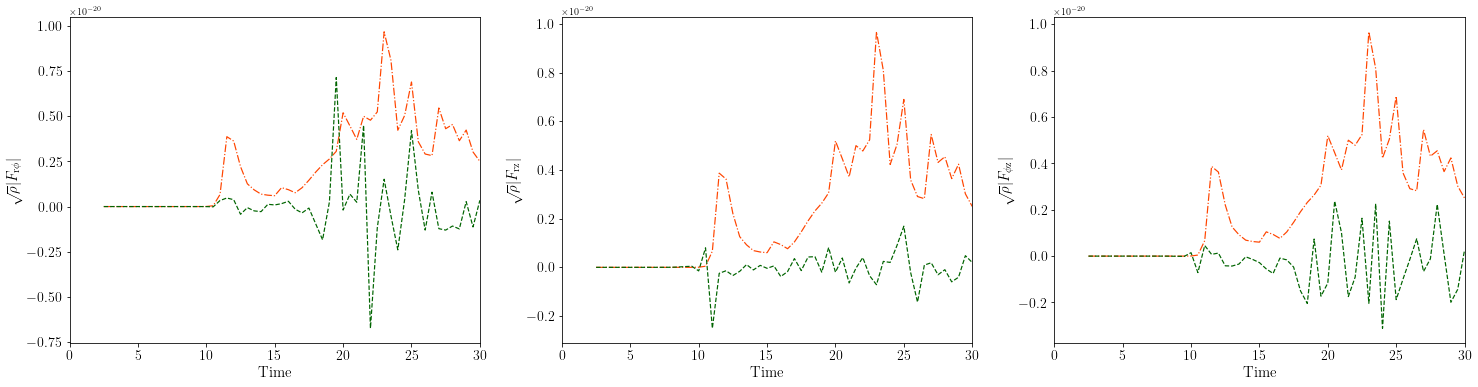

In [36]:
#plots faraday
    
fig, ax = plt.subplots(1,3,sharex = 'all', sharey = 'none', figsize = (25,6))

for i in range(0,3):
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].tick_params(axis='x',labelsize = 14)
    
plt.subplots_adjust(wspace = 0.2) 

#ax[0].plot(t[5:],F1[5:,0], linewidth = 1.2, linestyle = 'solid', color = 'limegreen', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
#ax[0].plot(t[5:],F3[5:,0], linewidth = 1.2, linestyle = 'dashdot', color = 'yellowgreen', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],1.5*R2[5:,5], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered')

ax[0].plot(t[5:],F2[5:,0], linewidth = 1.2, linestyle = 'dashed', color = 'darkgreen', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
#ax[0].set_yscale('log')
#ax[0].set_ylim([1e-32,1e-20])
ax[0].set_ylabel(r'$\sqrt{\rho} |F_{\rm r\phi}|$', fontsize = 15)
ax[0].set_xlabel('Time', fontsize = 15)
#ax[0].legend(loc = 'lower right', fontsize = 14)

#ax[1].plot(t[5:],F1[5:,1], linewidth = 1.2, linestyle = 'solid', color = 'limegreen', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
#ax[1].plot(t[5:],F3[5:,1], linewidth = 1.2, linestyle = 'dashdot', color = 'yellowgreen', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],1.5*R2[5:,5], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered')

ax[1].plot(t[5:],F2[5:,1], linewidth = 1.2, linestyle = 'dashed', color = 'darkgreen', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
#ax[1].set_yscale('log')
#ax[1].set_ylim([1e-32,1e-20])
ax[1].set_ylabel(r'$\sqrt{\rho} |F_{\rm rz}|$', fontsize = 15)
ax[1].set_xlabel('Time', fontsize = 15)
#ax[1].legend(loc = 'lower right', fontsize = 14)

#ax[2].plot(t[5:],F1[5:,2], linewidth = 1.2, linestyle = 'solid', color = 'limegreen', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
#ax[2].plot(t[5:],F3[5:,2], linewidth = 1.2, linestyle = 'dashdot', color = 'yellowgreen', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],1.5*R2[5:,5], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered')

ax[2].plot(t[5:],F2[5:,2], linewidth = 1.2, linestyle = 'dashed', color = 'darkgreen', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
#ax[2].set_yscale('log')
#ax[2].set_ylim([-1e-50,1e-50])
ax[2].set_xlim([0,30])

ax[2].set_ylabel(r'$\sqrt{\rho} |F_{\rm \phi z}|$', fontsize = 15)
ax[2].set_xlabel('Time', fontsize = 15)
#ax[2].legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_faraday_comp_400.pdf',bbox_inches = 'tight')

plt.show()
    

In [5]:
#plots stresses

path_stresses = '/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/'
path_blow = path_stresses+'volume_av/b0z-2.76e13'
path_bhigh = path_stresses+'volume_av/b0z-3.45e13'
path_bmed = path_stresses+'volume_av/b0z-4.6e13'


M1 = np.zeros((len(t),6))
R1 = np.zeros((len(t),6))
F1 = np.zeros((len(t),3))
eT1 = np.zeros(len(t))
rho1 = np.zeros(len(t))

M2 = np.zeros((len(t),6))
R2 = np.zeros((len(t),6))
F2 = np.zeros((len(t),3))
eT2 = np.zeros(len(t))
rho2 = np.zeros(len(t))

M3 = np.zeros((len(t),6))
R3 = np.zeros((len(t),6))
F3 = np.zeros((len(t),3))
eT3 = np.zeros(len(t))
rho3 = np.zeros(len(t))

for tt in range(0, len(t)):

    arx = format(25*tt, "04")
    M1[tt], R1[tt], F1[tt], eT1[tt], rho1[tt] = readstresses(path_blow+'/stresses_sigma_whole_box-'+arx+'.h5')
    M2[tt], R2[tt], F2[tt], eT2[tt], rho2[tt] = readstresses(path_bhigh+'/stresses_sigma_whole_box-'+arx+'.h5')
    M3[tt], R3[tt], F3[tt], eT3[tt], rho3[tt] = readstresses(path_bmed+'/stresses_sigma_whole_box-'+arx+'.h5')

M1trace = M1[:,0]+M1[:,3]+M1[:,5]
M2trace = M2[:,0]+M2[:,3]+M2[:,5]
M3trace = M3[:,0]+M3[:,3]+M3[:,5]
R1trace = R1[:,0]+R1[:,3]+R1[:,5]
R2trace = R2[:,0]+R2[:,3]+R2[:,5]
R3trace = R3[:,0]+R3[:,3]+R3[:,5]

DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/volume_av/b0z-2.76e13/stresses_sigma_whole_box-0000.h5
Keys: <KeysViewHDF5 ['Fmean', 'Mmean', 'Rmean', 'rhomean', 'sigma_F', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
Fmean
Mmean
Rmean
rhomean
sigma_F
sigma_M
sigma_R
sigma_rho
time
Time           : 0.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/volume_av/b0z-3.45e13/stresses_sigma_whole_box-0000.h5
Keys: <KeysViewHDF5 ['Fmean', 'Mmean', 'Rmean', 'rhomean', 'sigma_F', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
Fmean
Mmean
Rmean
rhomean
sigma_F
sigma_M
sigma_R
sigma_rho
time
Time           : 0.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/volume_av/b0z-4.6e13/stresses_sigma_whole_box-0000.h5
Keys:

Keys: <KeysViewHDF5 ['Fmean', 'Mmean', 'Rmean', 'rhomean', 'sigma_F', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
Fmean
Mmean
Rmean
rhomean
sigma_F
sigma_M
sigma_R
sigma_rho
time
Time           : 19.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/volume_av/b0z-3.45e13/stresses_sigma_whole_box-0950.h5
Keys: <KeysViewHDF5 ['Fmean', 'Mmean', 'Rmean', 'rhomean', 'sigma_F', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
Fmean
Mmean
Rmean
rhomean
sigma_F
sigma_M
sigma_R
sigma_rho
time
Time           : 19.0  ms
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/stress_tensors_r0/res_100_400_100/volume_av/b0z-4.6e13/stresses_sigma_whole_box-0950.h5
Keys: <KeysViewHDF5 ['Fmean', 'Mmean', 'Rmean', 'rhomean', 'sigma_F', 'sigma_M', 'sigma_R', 'sigma_rho', 'time']>
Fmean
Mmean
Rmean
rhomean
sigma_F
sigma_M
sigma_R
sigma_rho
time
Time           : 19.

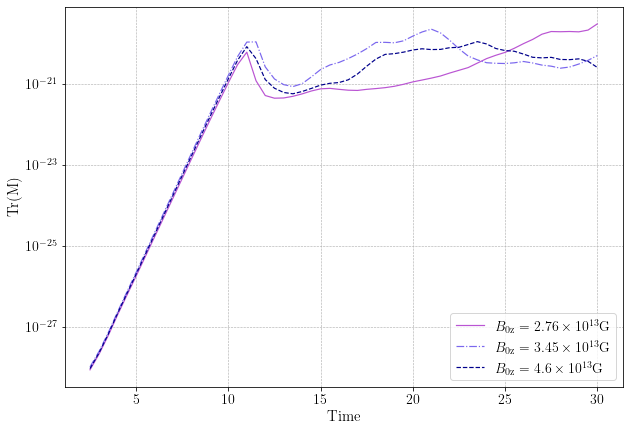

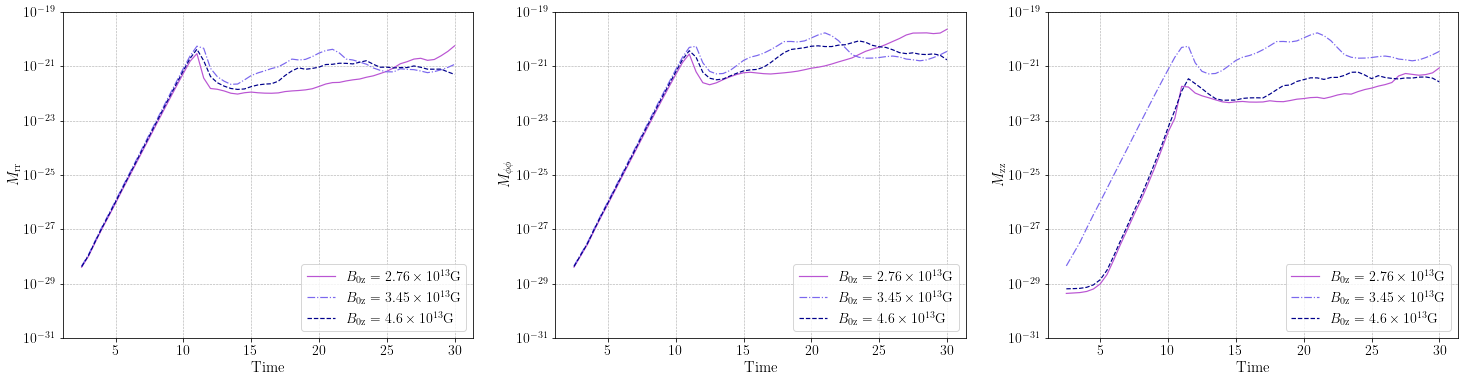

In [67]:
#plots maxwell

fig, ax = plt.subplots(figsize = (10,7))

ax.tick_params(axis='y',labelsize = 14)
ax.tick_params(axis='x',labelsize = 14)

ax.plot(t[5:],M1trace[5:], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax.plot(t[5:],M3trace[5:], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax.plot(t[5:],M2trace[5:], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax.set_ylabel(r'$\rm{Tr}(M)$', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_yscale('log')
ax.grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
#ax.set_xscale('log')
ax.legend(loc = 'lower right', fontsize = 14)

plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_trace_maxwell_vol_400.pdf',bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(1,3,sharex = 'all', sharey = 'none', figsize = (25,6))

for i in range(0,3):
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].tick_params(axis='x',labelsize = 14)
    
plt.subplots_adjust(wspace = 0.2) 

ax[0].plot(t[5:],M1[5:,0], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],M3[5:,0], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],M2[5:,0], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax[0].set_yscale('log')
ax[0].set_ylim([1e-31,1e-19])
ax[0].set_ylabel(r'$M_{\rm rr}$', fontsize = 15)
ax[0].set_xlabel('Time', fontsize = 15)
ax[0].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
ax[0].legend(loc = 'lower right', fontsize = 14)

ax[1].plot(t[5:],M1[5:,3], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],M3[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],M2[5:,3], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[1].set_yscale('log')
ax[1].set_ylim([1e-31,1e-19])
ax[1].set_ylabel(r'$M_{\rm \phi\phi}$', fontsize = 15)
ax[1].set_xlabel('Time', fontsize = 15)
ax[1].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
ax[1].legend(loc = 'lower right', fontsize = 14)

ax[2].plot(t[5:],M1[5:,5], linewidth = 1.2, linestyle = 'solid', color = 'mediumorchid', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],M3[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'mediumslateblue', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],M2[5:,5], linewidth = 1.2, linestyle = 'dashed', color = 'darkblue', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[2].set_yscale('log')
ax[2].set_ylim([1e-31,1e-19])
ax[2].set_ylabel(r'$M_{\rm zz}$', fontsize = 15)
ax[2].set_xlabel('Time', fontsize = 15)
ax[2].grid(axis = 'both',which = 'major', linestyle = '--', linewidth = 0.6)
ax[2].legend(loc = 'lower right', fontsize = 14)

plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_maxwell_comp__vol_400.pdf',bbox_inches = 'tight')
plt.show()

In [68]:
#plots reynolds

for i in range(0,6):
    R1[:,i] = R1[:,i]*rho1[:]
    R2[:,i] = R2[:,i]*rho2[:]
    R3[:,i] = R3[:,i]*rho3[:]
    
R1trace[:] = R1trace[:]*rho1[:]
R2trace[:] = R2trace[:]*rho2[:]
R3trace[:] = R3trace[:]*rho3[:]


fig, ax = plt.subplots(figsize = (10,7))

ax.tick_params(axis='y',labelsize = 14)
ax.tick_params(axis='x',labelsize = 14)

ax.plot(t[5:],R1trace[5:], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label = r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax.plot(t[5:],R3trace[5:], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax.plot(t[5:],R2trace[5:], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label = r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')

ax.set_ylabel(r'$\rho \rm{Tr}(R)$', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend(loc = 'lower right', fontsize = 14)

plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_trace_reynolds_vol_400.pdf',bbox_inches = 'tight')

plt.show()

fig, ax = plt.subplots(1,3,sharex = 'all', sharey = 'none', figsize = (25,6))

for i in range(0,3):
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].tick_params(axis='x',labelsize = 14)
    
plt.subplots_adjust(wspace = 0.2) 

ax[0].plot(t[5:],R1[5:,0], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],R3[5:,0], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],R2[5:,0], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[0].set_yscale('log')
ax[0].set_ylim([1e-30,1e-19])
ax[0].set_ylabel(r'$\rho R_{\rm rr}$', fontsize = 15)
ax[0].set_xlabel('Time', fontsize = 15)
ax[0].legend(loc = 'lower right', fontsize = 14)

ax[1].plot(t[5:],R1[5:,3], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],R3[5:,3], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],R2[5:,3], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[1].set_yscale('log')
ax[1].set_ylim([1e-30,1e-19])
ax[1].set_ylabel(r'$\rho R_{\rm \phi\phi}$', fontsize = 15)
ax[1].set_xlabel('Time', fontsize = 15)
ax[1].legend(loc = 'lower right', fontsize = 14)

ax[2].plot(t[5:],R1[5:,5], linewidth = 1.2, linestyle = 'solid', color = 'goldenrod', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],R3[5:,5], linewidth = 1.2, linestyle = 'dashdot', color = 'orangered', label = r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],R2[5:,5], linewidth = 1.2, linestyle = 'dashed', color = 'darkred', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[2].set_yscale('log')
ax[2].set_ylim([1e-30,1e-19])
ax[2].set_ylabel(r'$\rho R_{\rm zz}$', fontsize = 15)
ax[2].set_xlabel('Time', fontsize = 15)
ax[2].legend(loc = 'lower right', fontsize = 14)

plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_reynolds_comp_vol_400.pdf',bbox_inches = 'tight')

plt.show()

In [6]:
#plots faraday

for i in range(0,3):
    F1[:,i] = abs(F1[:,i]*rho1**(0.5))
    F2[:,i] = abs(F2[:,i]*rho2**(0.5))
    F3[:,i] = abs(F3[:,i]*rho3**(0.5))
    
fig, ax = plt.subplots(1,3,sharex = 'all', sharey = 'none', figsize = (25,6))

for i in range(0,3):
    ax[i].tick_params(axis='y',labelsize = 14)
    ax[i].tick_params(axis='x',labelsize = 14)
    
plt.subplots_adjust(wspace = 0.2) 

ax[0].plot(t[5:],F1[5:,0], linewidth = 1.2, linestyle = 'solid', color = 'limegreen', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],F3[5:,0], linewidth = 1.2, linestyle = 'dashdot', color = 'yellowgreen', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[0].plot(t[5:],F2[5:,0], linewidth = 1.2, linestyle = 'dashed', color = 'darkgreen', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[0].set_yscale('log')
ax[0].set_ylim([1e-32,1e-20])
ax[0].set_ylabel(r'$\sqrt{\rho} |F_{\rm r\phi}|$', fontsize = 15)
ax[0].set_xlabel('Time', fontsize = 15)
ax[0].legend(loc = 'lower right', fontsize = 14)

ax[1].plot(t[5:],F1[5:,1], linewidth = 1.2, linestyle = 'solid', color = 'limegreen', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],F3[5:,1], linewidth = 1.2, linestyle = 'dashdot', color = 'yellowgreen', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[1].plot(t[5:],F2[5:,1], linewidth = 1.2, linestyle = 'dashed', color = 'darkgreen', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[1].set_yscale('log')
ax[1].set_ylim([1e-32,1e-20])
ax[1].set_ylabel(r'$\sqrt{\rho} |F_{\rm rz}|$', fontsize = 15)
ax[1].set_xlabel('Time', fontsize = 15)
ax[1].legend(loc = 'lower right', fontsize = 14)

ax[2].plot(t[5:],F1[5:,2], linewidth = 1.2, linestyle = 'solid', color = 'limegreen', label=r'$B_{\rm 0z} = 2.76\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],F3[5:,2], linewidth = 1.2, linestyle = 'dashdot', color = 'yellowgreen', label=r'$B_{\rm 0z} = 3.45\times 10^{13}\rm{ G}$')
ax[2].plot(t[5:],F2[5:,2], linewidth = 1.2, linestyle = 'dashed', color = 'darkgreen', label=r'$B_{\rm 0z} = 4.6\times 10^{13}\rm{ G}$')
ax[2].set_yscale('log')
ax[2].set_ylim([1e-32,1e-20])
ax[2].set_ylabel(r'$\sqrt{\rho} |F_{\rm \phi z}|$', fontsize = 15)
ax[2].set_xlabel('Time', fontsize = 15)
ax[2].legend(loc = 'lower right', fontsize = 14)

#plt.savefig('/home/miquelmiravet/Desktop/MRI_comparison_b0z_400/mri_faraday_comp_vol_400.pdf',bbox_inches = 'tight')

plt.show()